Sofia Alvarez Sandoval - A01656059

# Examen argumentativo práctico
## MA2007 - Uso de geometría y topología para ciencia de datos

In [310]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kmapper as km
import sklearn
from nolitsa import delay, dimension
import gudhi
import ripser
import persim

## Lectura y primera exploración de los datos

In [311]:
d1 = pd.read_csv('KwhConsumptionBlower78_1.csv')
d1['Origin'] = pd.Series(['1']*len(d1))
d2 = pd.read_csv('KwhConsumptionBlower78_2.csv')
d2['Origin'] = pd.Series(['2']*len(d2))
d3 = pd.read_csv('KwhConsumptionBlower78_3.csv')
d3['Origin'] = pd.Series(['3']*len(d3))

df = pd.concat([d1, d2, d3], ignore_index=True)

In [312]:
print('Tipo de datos por variable:')
print(df.dtypes)
print('\n')

print('Muestra de los registros:')
print(df.head())

Tipo de datos por variable:
Unnamed: 0       int64
TxnDate         object
TxnTime         object
Consumption    float64
Origin          object
dtype: object


Muestra de los registros:
   Unnamed: 0      TxnDate   TxnTime  Consumption Origin
0       76229  01 Jan 2022  16:55:52        1.010      1
1       76258  01 Jan 2022  21:45:29        0.908      1
2       76287  01 Jan 2022  12:24:52        0.926      1
3       76316  01 Jan 2022  04:07:36        0.928      1
4       76345  01 Jan 2022  06:52:25        0.916      1


### Limpieza de datos

En la página de Kaggle, el autor señala que los valores de 0.5 y menores son errores en la medición, por lo que se eliminan para no afectar el análisis posterior. También se eliminan valores faltantes.

In [313]:
df = df[df['Consumption'] > 0.5]
df = df.dropna()

df['Consumption'].describe()

count    3603.000000
mean        2.783741
std         2.961468
min         0.588000
25%         0.948000
50%         1.032000
75%         4.008000
max        27.284000
Name: Consumption, dtype: float64

Dado que existe una diferencia importante entre la media y el valor superior, se eliminan los valores atípicos superiores (mayores al porcentil 90) para facilitar la detección de periodicidad.

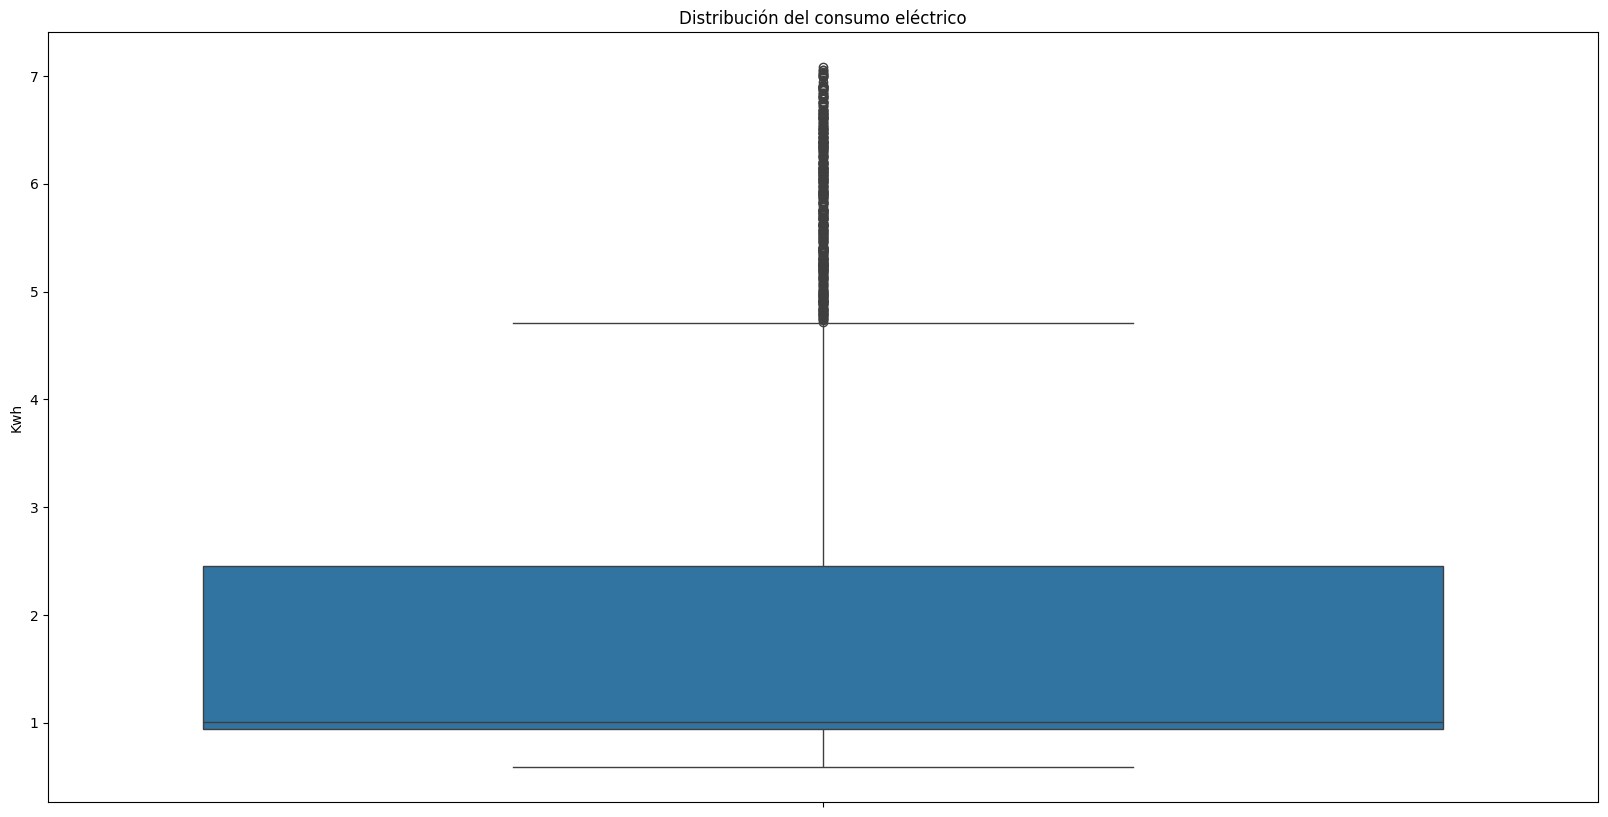

In [314]:
df = df[df['Consumption'] < df['Consumption'].quantile(0.9)]

# Boxplot for consumption
plt.figure(figsize=(20,10))
sns.boxplot(df['Consumption'])
plt.title('Distribución del consumo eléctrico')
plt.ylabel('Kwh')
plt.show()

In [315]:
df['Consumption'].describe()

count    3242.000000
mean        2.025969
std         1.735772
min         0.588000
25%         0.944000
50%         1.008000
75%         2.452500
max         7.082000
Name: Consumption, dtype: float64

Se procesan las columnas de tiempo y hora como una sola, y se eliminan las variables no deseadas

In [186]:
data = df.copy()

# Join date and time columns as datetime format
data['DateTime'] = pd.to_datetime(data['TxnDate'] + ' ' + data['TxnTime'])
data = data.sort_values(by='DateTime')

# Add numeric index according to the date
index_map = dict(zip(data['TxnDate'].unique(), range(len(data['TxnDate'].unique()))))
data['DateIndex'] = data['TxnDate'].map(index_map)

# Drop unnecesary columns
data = data.drop(['TxnDate', 'TxnTime','Unnamed: 0'], axis=1)

# Reorganize columns
data = data[['DateIndex','DateTime','Consumption','Origin']]
data.reset_index(drop=True, inplace=True)

### Visualización de la serie de tiempo

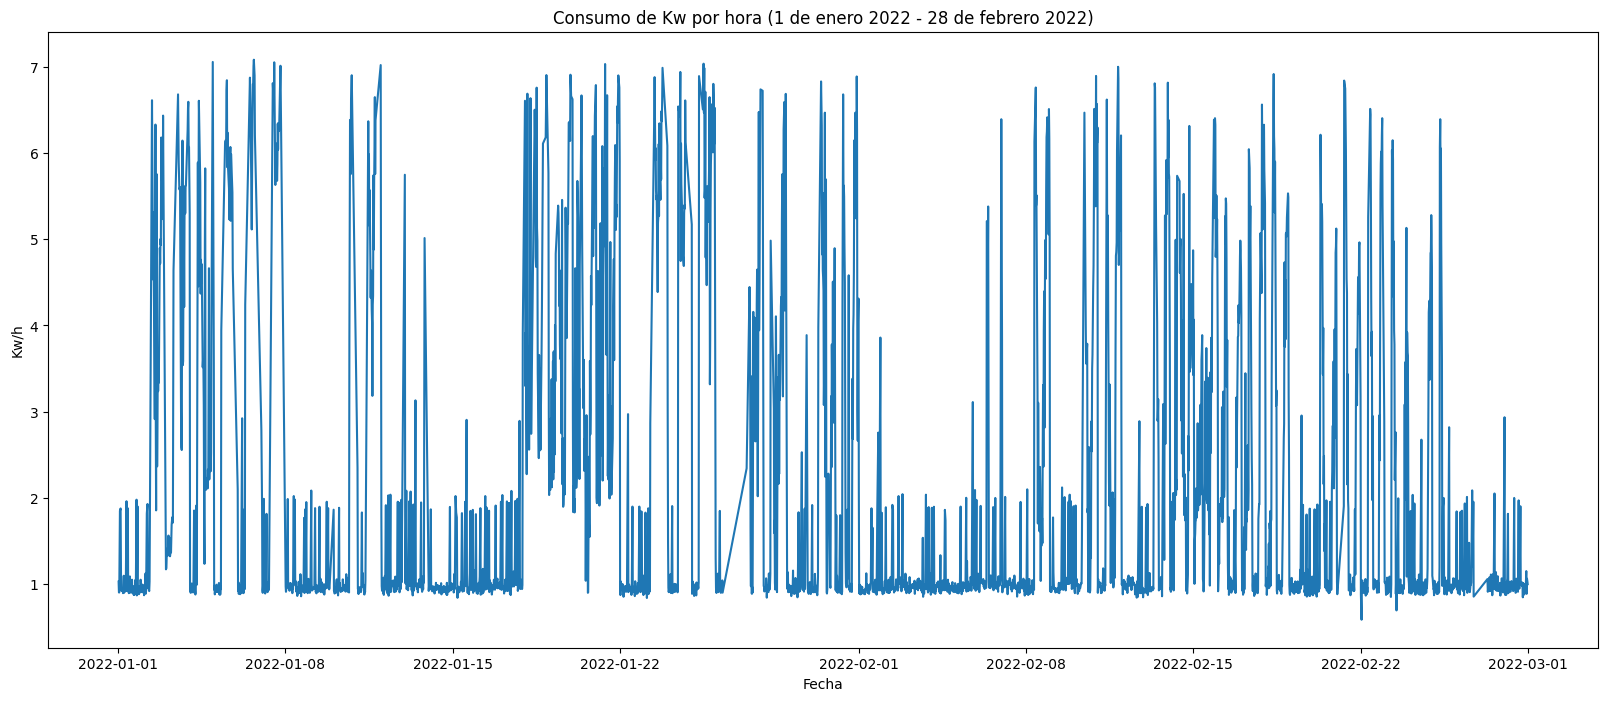

In [187]:
plt.figure(figsize=(20,8))
plt.plot(data['DateTime'], data['Consumption'])
plt.title('Consumo de Kw por hora (1 de enero 2022 - 28 de febrero 2022)')
plt.xlabel('Fecha')
plt.ylabel('Kw/h')
plt.show()

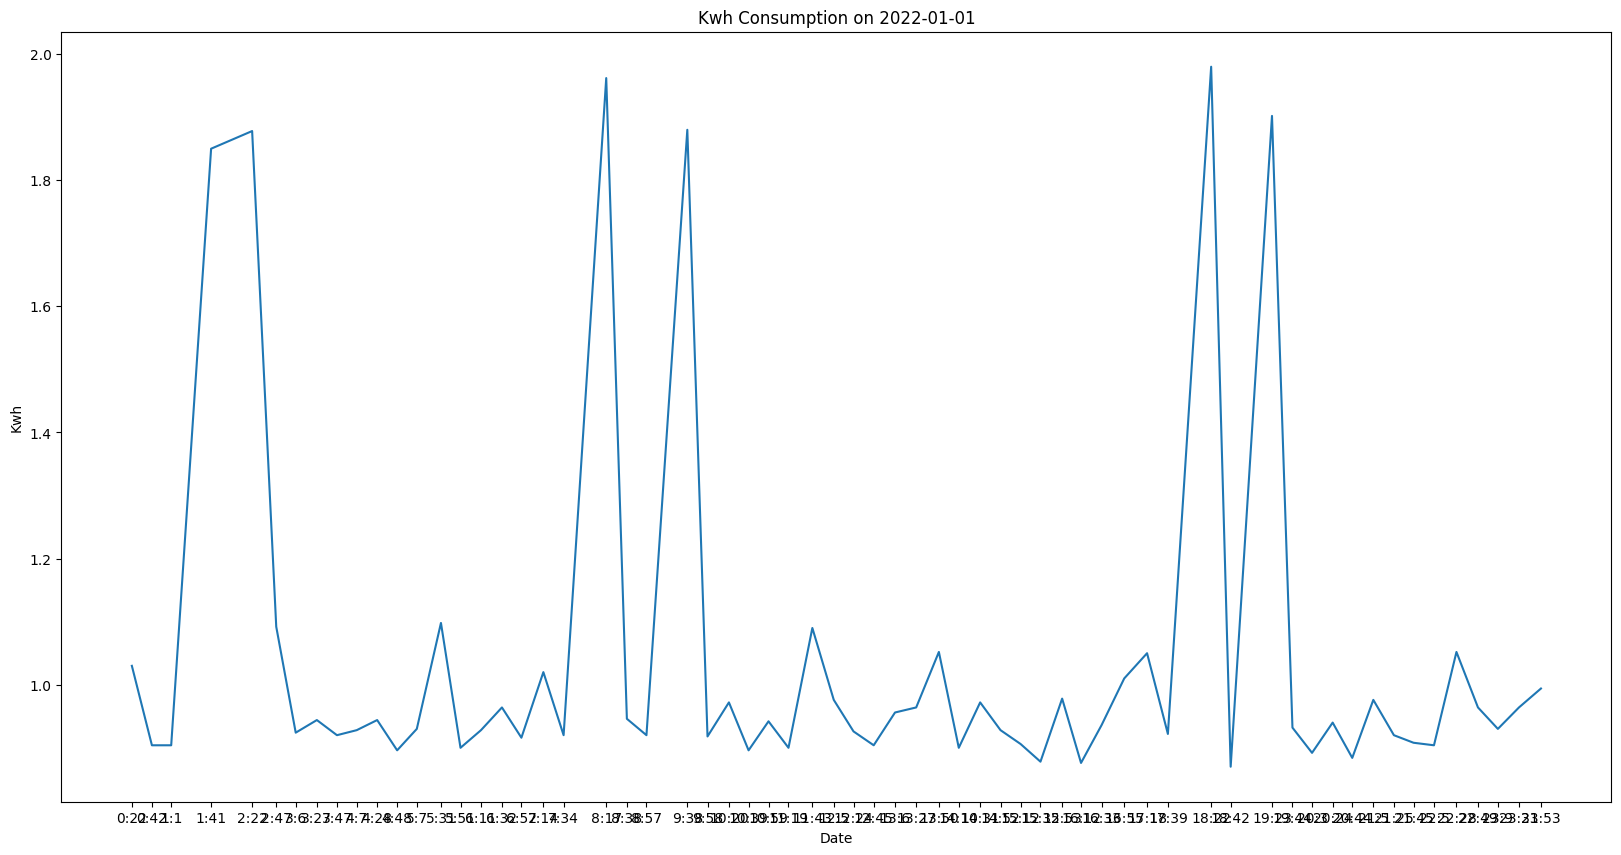

In [188]:
# Graph data for one day
plt.figure(figsize=(20,10))
plt.plot(data[data['DateIndex']==0]['DateTime'], data[data['DateIndex']==0]['Consumption'])

# Get hour + minutes for x labels
h_d1 = data[data['DateIndex']==0]['DateTime'].dt.hour.values
m_d1 = data[data['DateIndex']==0]['DateTime'].dt.minute.values
hm_d1 = []
hm_d1 = hm_d1 + [str(h_d1[i]) + ':' + str(m_d1[i]) for i in range(len(h_d1))]

plt.xticks(data[data['DateIndex']==0]['DateTime'], hm_d1)
plt.title('Kwh Consumption on 2022-01-01')
plt.xlabel('Date')
plt.ylabel('Kwh')
plt.show()

In [189]:
# Get average number of records per day
print('Cantidad de registros promedio por día:', data.groupby('DateIndex').count()['DateTime'].mean())
print('Cantidad mínima de registros por día:', data.groupby('DateIndex').count()['DateTime'].min())
print('Cantidad máxima de registros por día:', data.groupby('DateIndex').count()['DateTime'].max())

Cantidad de registros promedio por día: 54.94915254237288
Cantidad mínima de registros por día: 20
Cantidad máxima de registros por día: 69


### Descomposición en serie de tiempo

Como una primer exploración se usa la paquetería 'statsmodels' para analizar los datos como una serie de tiempo aditiva y así detectar si existe una tendencia y alguna potencial periodicidad.

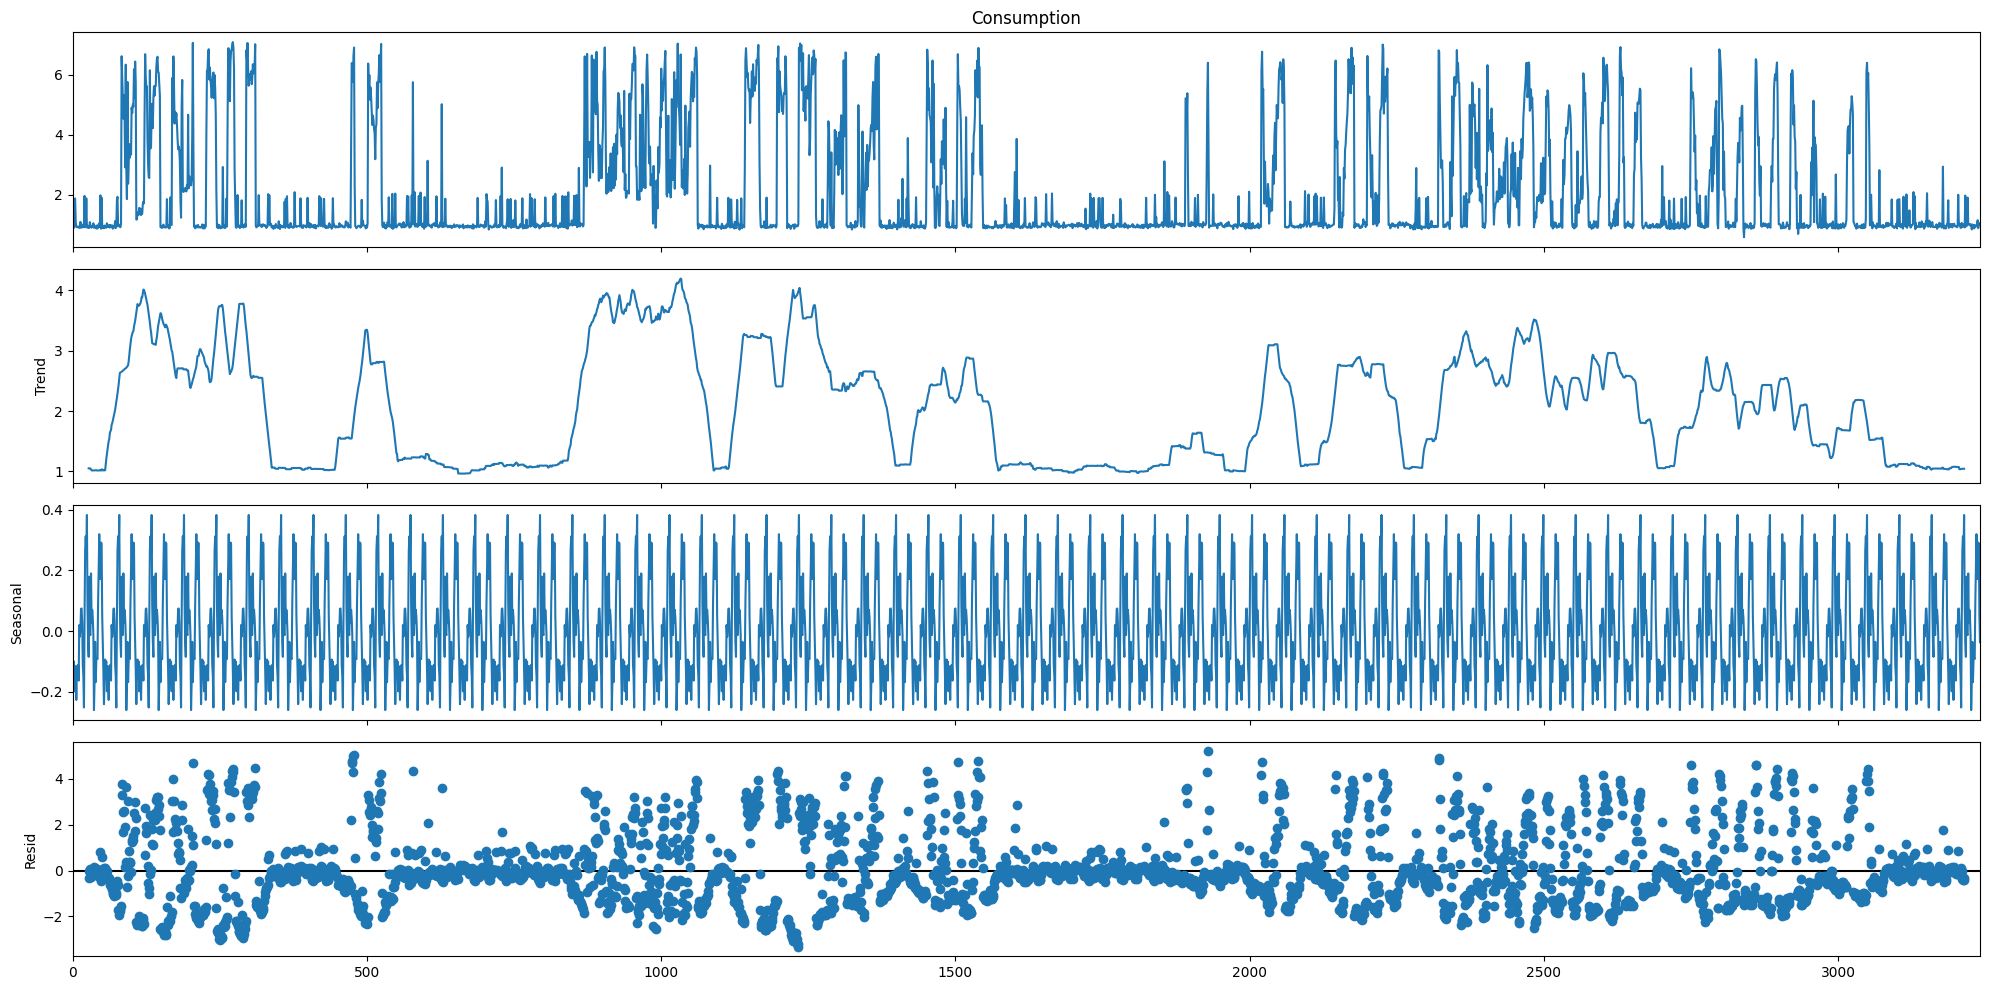

In [193]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Consumption'], model='additive', period=55)
plt.rc('figure', figsize=(20,10))
result.plot()
plt.show()

Se realiza un descomposición adicional para cada base de datos usada, a fin de caracterizar comportamientos particulares en cada uno.

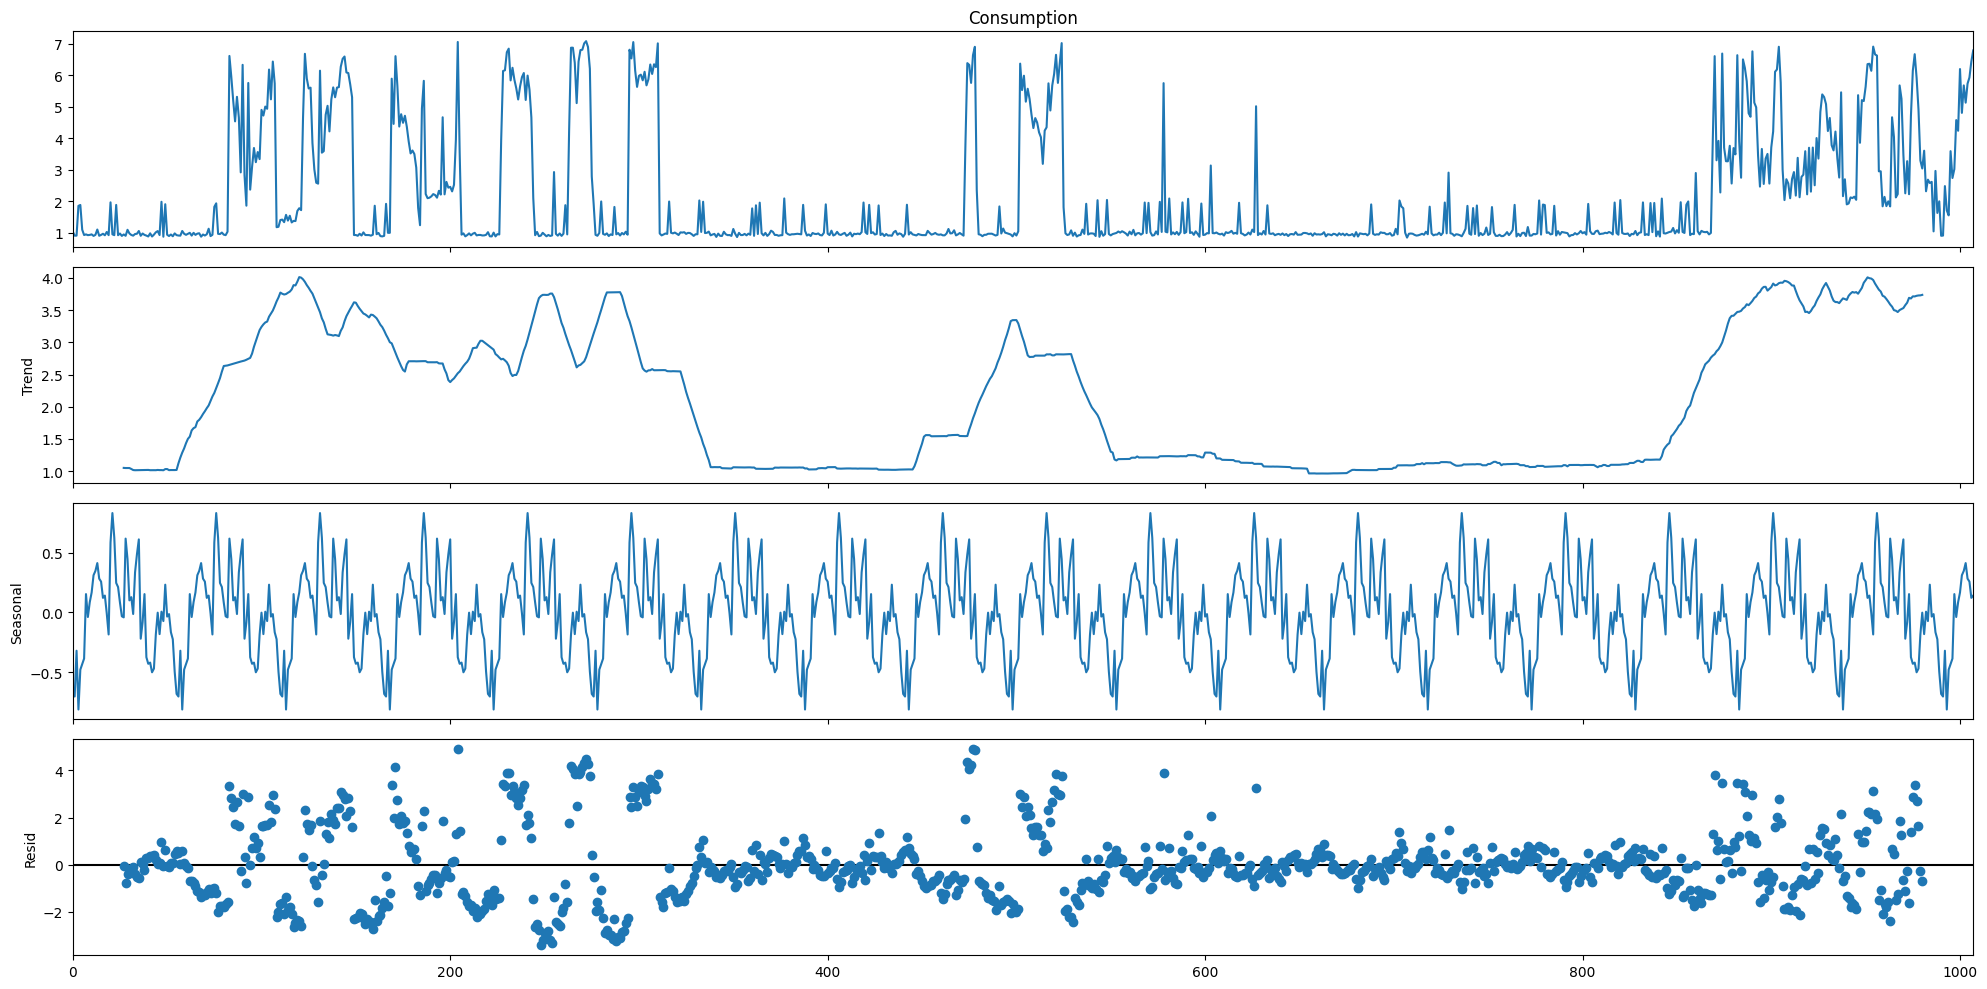

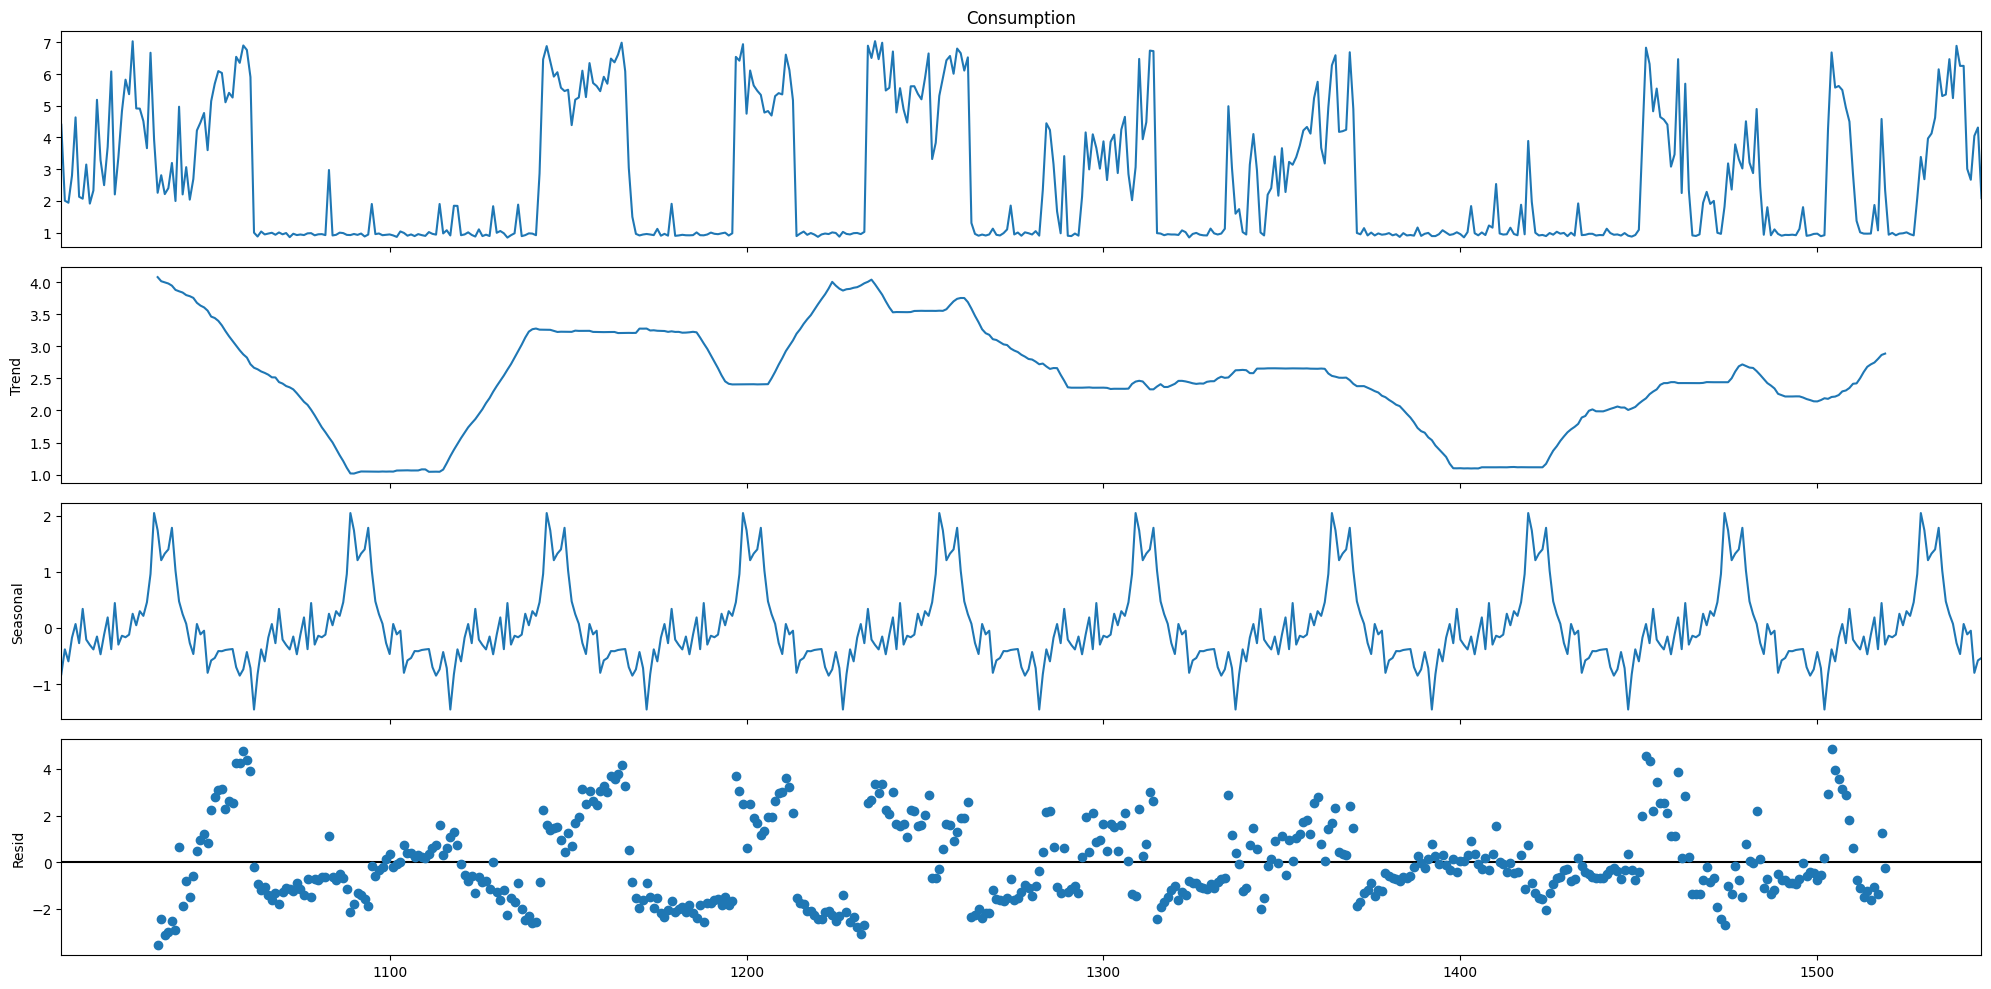

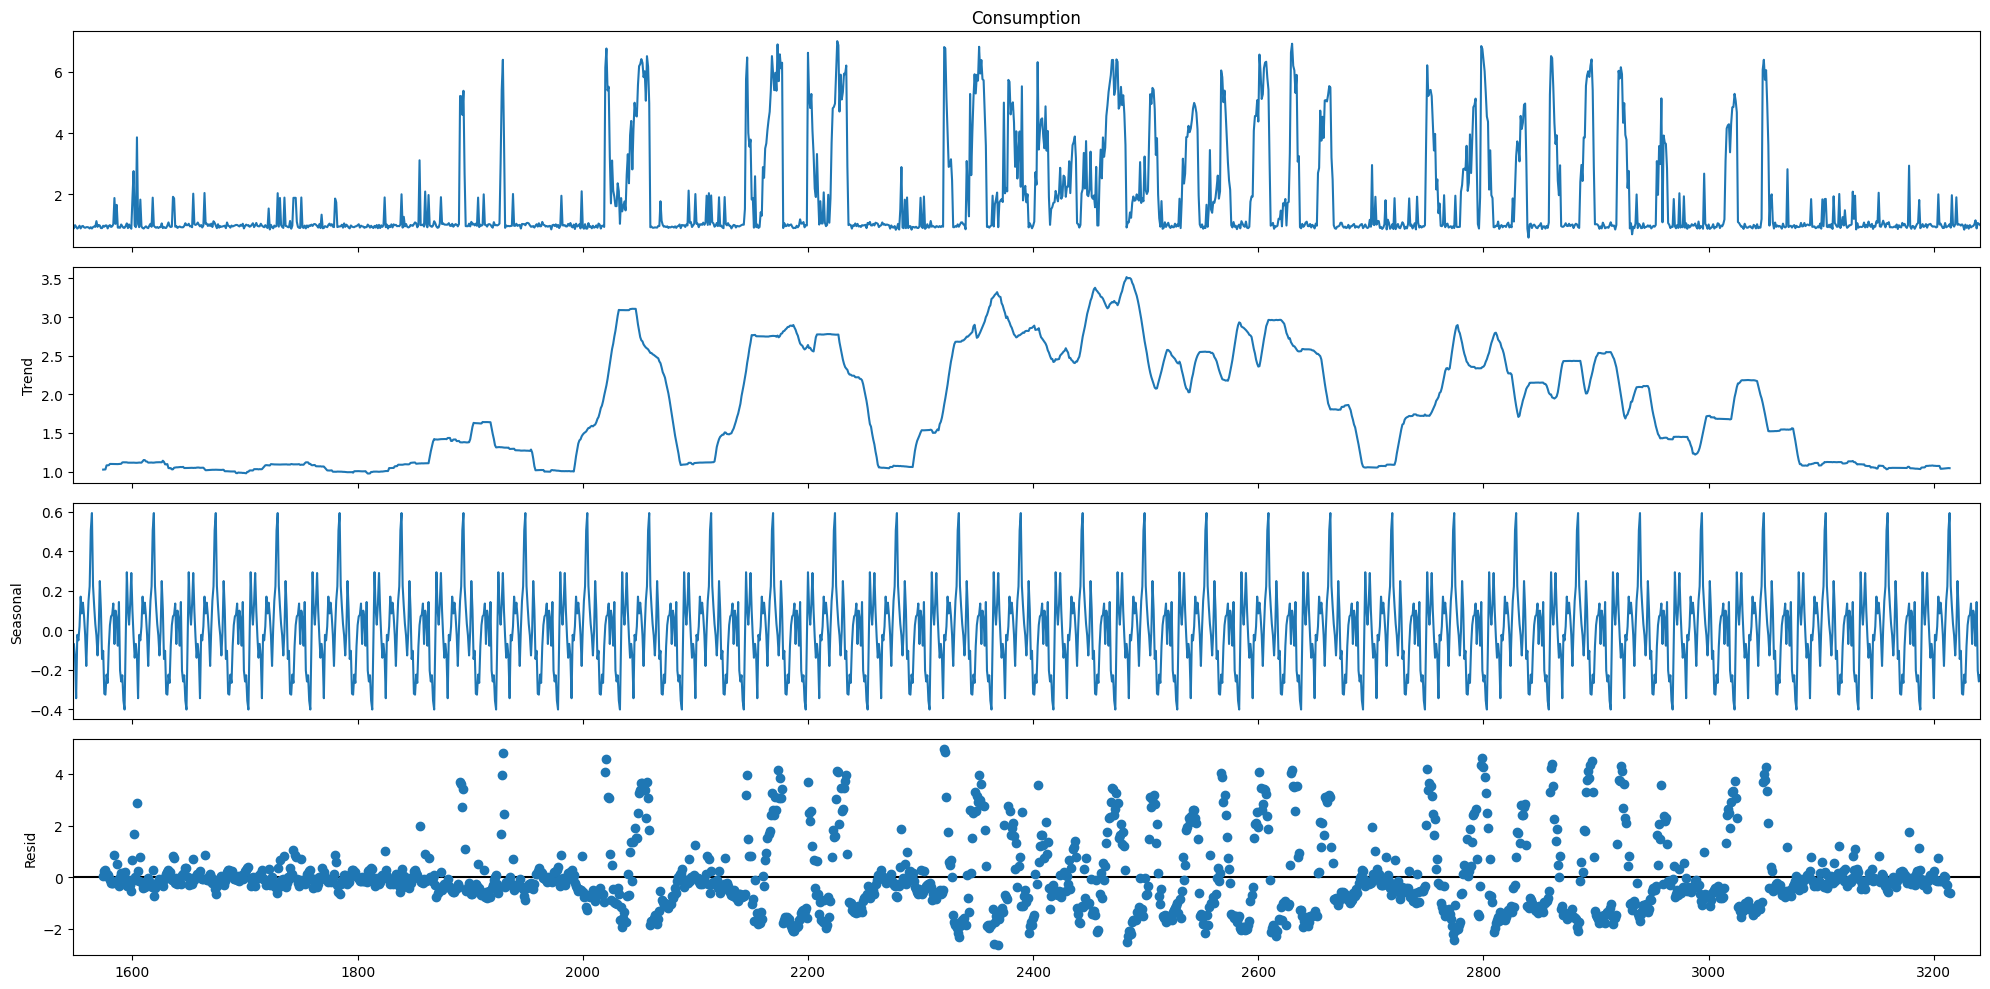

In [194]:
# Generate separate additive decompostions by 'origin'

data1 = data[data['Origin'] == '1']
r1 = seasonal_decompose(data1['Consumption'], model='additive', period=55)
plt.rc('figure', figsize=(20,10))
r1.plot()
plt.show()


data2 = data[data['Origin'] == '2']
r2 = seasonal_decompose(data2['Consumption'], model='additive', period=55)
plt.rc('figure', figsize=(20,10))
r2.plot()
plt.show()


data3 = data[data['Origin'] == '3']
r3 = seasonal_decompose(data3['Consumption'], model='additive', period=55)
plt.rc('figure', figsize=(20,10))
r3.plot()
plt.show()

Observemos que no es posible analizar la serie de tiempo por métodos tradicionales de decomposición para detectar periodicidad ni tendencias, puesto que no existe un comportamiento que sea constante ni que describa apropiadamente a todos los datos, por lo que será de utilidad analizarlo mediante TDA.

## Encaje de Takens

In [12]:
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud, plot_diagram

Se extrae la variable 'Consumption' para realizar el encaje, adaptándola al formato necesario para las funciones siguientes:

In [196]:
cons = data['Consumption'].values
cons = pd.Series(cons)
SOI = cons.values.reshape(-1)
print (SOI.shape)

(3242,)


Se plantea un primer encaje, donde no se especifican parámetros a fin de que el algoritmo elija los valores óptimos:

In [197]:
# Convert time series to persistence diagram
persistence = SingleTakensEmbedding(parameters_type="search", n_jobs=2)

# Fit transform the time series
diagram = persistence.fit_transform(SOI)
diagram = diagram.reshape(1,*diagram.shape)

print(diagram.shape)

Se realiza un PCA para evaluar la contribución de cada dimensión y determinar la menor cantidad de dimensiones posibles

In [198]:
from sklearn.decomposition import PCA

diag = diagram[0]

pca = PCA(n_components=3)
comps = pca.fit_transform(diag)

pca.explained_variance_ratio_

array([0.8428424 , 0.09354242, 0.03687306])

Se calcula el complejo de Rips con los datos resultantes del PCA

In [199]:
# Calculating persistent homology
homology = VietorisRipsPersistence(metric="euclidean", homology_dimensions=(0, 1), n_jobs=-1)
comps3 = comps.reshape(1, *comps.shape)
homology_diagram = homology.fit_transform(comps3)

In [200]:
# Plot the persistent homology
plot_diagram(homology_diagram[0])

Observamos que existen múltiples nodos de $H_1$ cuya muerte ocurre significativamente después de su nacimiento, hablando de una persistencia importante (y de la potencial existencia de más de una periodicidad simultánea en los datos).

In [201]:
def plot_rips_complex(data, R, label=" data" , col=1 , maxdim=2):
    tab10 = plt.get_cmap('tab10')
    
    fig, ax = plt.subplots(figsize =(6,6))
    ax.set_title(label)
    ax.scatter(
        data [:,0], data[:,1], label=label,
        s=8, alpha=0.9, c=np.array(tab10([col] * len(data)))
    )
    
    for i , xy in enumerate(data):
        if maxdim >= 1:
            for j in range(i + 1, len(data)):
                pq = data[j]
                if (xy != pq) . all() and (np.linalg.norm(xy - pq) <= R):
                    pts = np.array([xy ,pq])
                    ax.plot(pts[:,0], pts[:,1], color="pink", alpha=0.05, linewidth=1)
                if maxdim == 2:
                    for k in range (j + 1 ,len(data)):
                        ab = data[k]
                        if((ab != pq) . all () 
                            and (np.linalg.norm(xy - pq) <= R) 
                            and (np.linalg.norm(xy - ab) <= R)
                            and (np.linalg.norm(pq - ab) <= R)
                        ):
                            pts = np.array([xy, pq, ab])
                            ax.fill(pts[:,0], pts[:,1], facecolor="red", alpha=0.05)
                        pass
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    pass

Se calcula un nuevo encaje, tomando como dimensión el número de componentes del PCA que generan la proporción más significativa de información según la varianza que representaba cada uno (en este caso, 2)

In [202]:
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=1,
    dimension=2,
    stride=1,
)

y_periodic_embedded = embedder_periodic.fit_transform(cons)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
plot_point_cloud(y_periodic_embedded)

Shape of embedded time series: (3241, 2)


In [203]:
def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)]) 

Se obtiene un nuevo diagrama de persistencia con los datos generados por el nuevo encaje:

In [204]:
dgmX = ripser.ripser(y_periodic_embedded)['dgms']

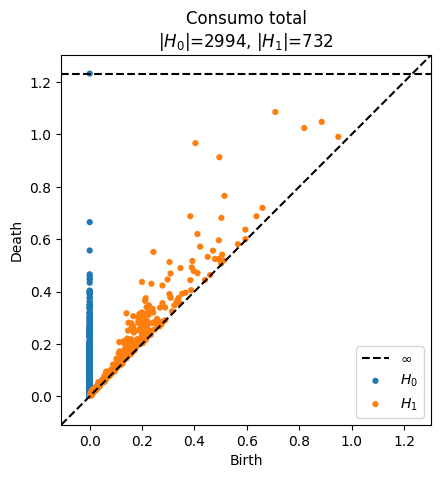

In [205]:
plt.rcParams.update(plt.rcParamsDefault)

persim.plot_diagrams(
    dgmX,
    show=True,
    title = f"Consumo total\n{diagram_sizes(dgmX)}"
)

Nuevamente se observa

## Interpolación

In [206]:
from scipy.interpolate import CubicSpline
spl = CubicSpline(np.linspace(0,len(cons),len(cons)), cons)

In [207]:
new_x = np.linspace(0,len(cons),58*96)
new_y = spl(new_x)

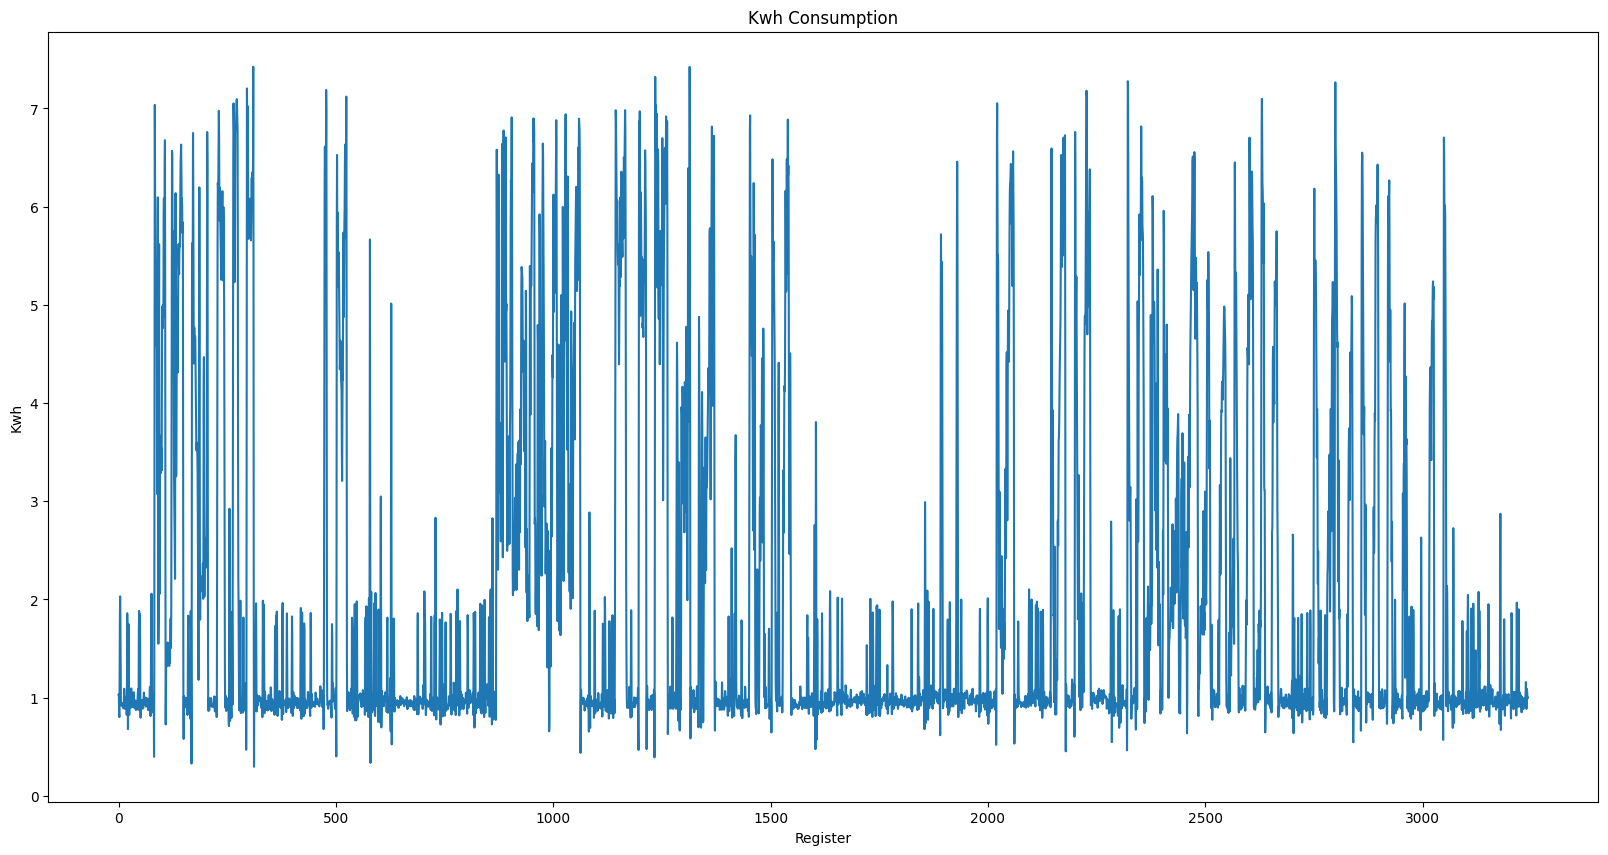

In [208]:
plt.figure(figsize=(20,10))
plt.plot(new_x, new_y)
plt.title('Kwh Consumption')
plt.xlabel('Register')
plt.ylabel('Kwh')
plt.show()

### Nuevo encaje

In [209]:
int_data = np.concatenate((new_x.reshape(-1,1), new_y.reshape(-1,1)), axis=1)

ts = int_data[:,1].astype(np.float64).flatten()
ts = pd.Series(ts)
SOI = ts.values.reshape(-1)
print (SOI.shape)

(5568,)


In [210]:
# Convert time series to persistence diagram
persistence = SingleTakensEmbedding(parameters_type="search", n_jobs=2)

# Fit transform the time series
diagram = persistence.fit_transform(SOI)
diagram = diagram.reshape(1,*diagram.shape)

In [211]:
diag = diagram[0]

pca = PCA(n_components=3)
comps = pca.fit_transform(diag)

pca.explained_variance_ratio_

array([0.89102984, 0.07640234, 0.02538872])

In [212]:
# Calculating persistent homology
homology = VietorisRipsPersistence(metric="euclidean", homology_dimensions=(0, 1), n_jobs=-1)
comps3 = comps.reshape(1, *comps.shape)
homology_diagram = homology.fit_transform(comps3)

In [213]:
plot_diagram(homology_diagram[0])

In [214]:
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=1,
    dimension=2,
    stride=1,
)

y_periodic_embedded = embedder_periodic.fit_transform(cons)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
plot_point_cloud(y_periodic_embedded)

Shape of embedded time series: (3241, 2)


In [215]:
dgmX = ripser.ripser(y_periodic_embedded)['dgms']

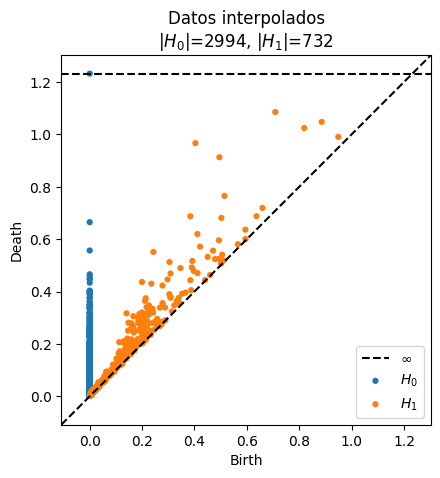

In [216]:
plt.rcParams.update(plt.rcParamsDefault)

persim.plot_diagrams(
    dgmX,
    show=True,
    title=f"Datos interpolados\n{diagram_sizes(dgmX)}"
)

## Análisis por horario (día y noche)

In [34]:
# Separate day and night consumption
day_cons = data.loc[(pd.Timestamp('06:00').time()<=data['DateTime'].dt.time)&(data['DateTime'].dt.time<pd.Timestamp('18:00').time())]
day_cons = day_cons.sort_values(by='DateTime')

night_cons = data.loc[day_cons.index.symmetric_difference(data.index)]
night_cons = night_cons.sort_values(by='DateTime')

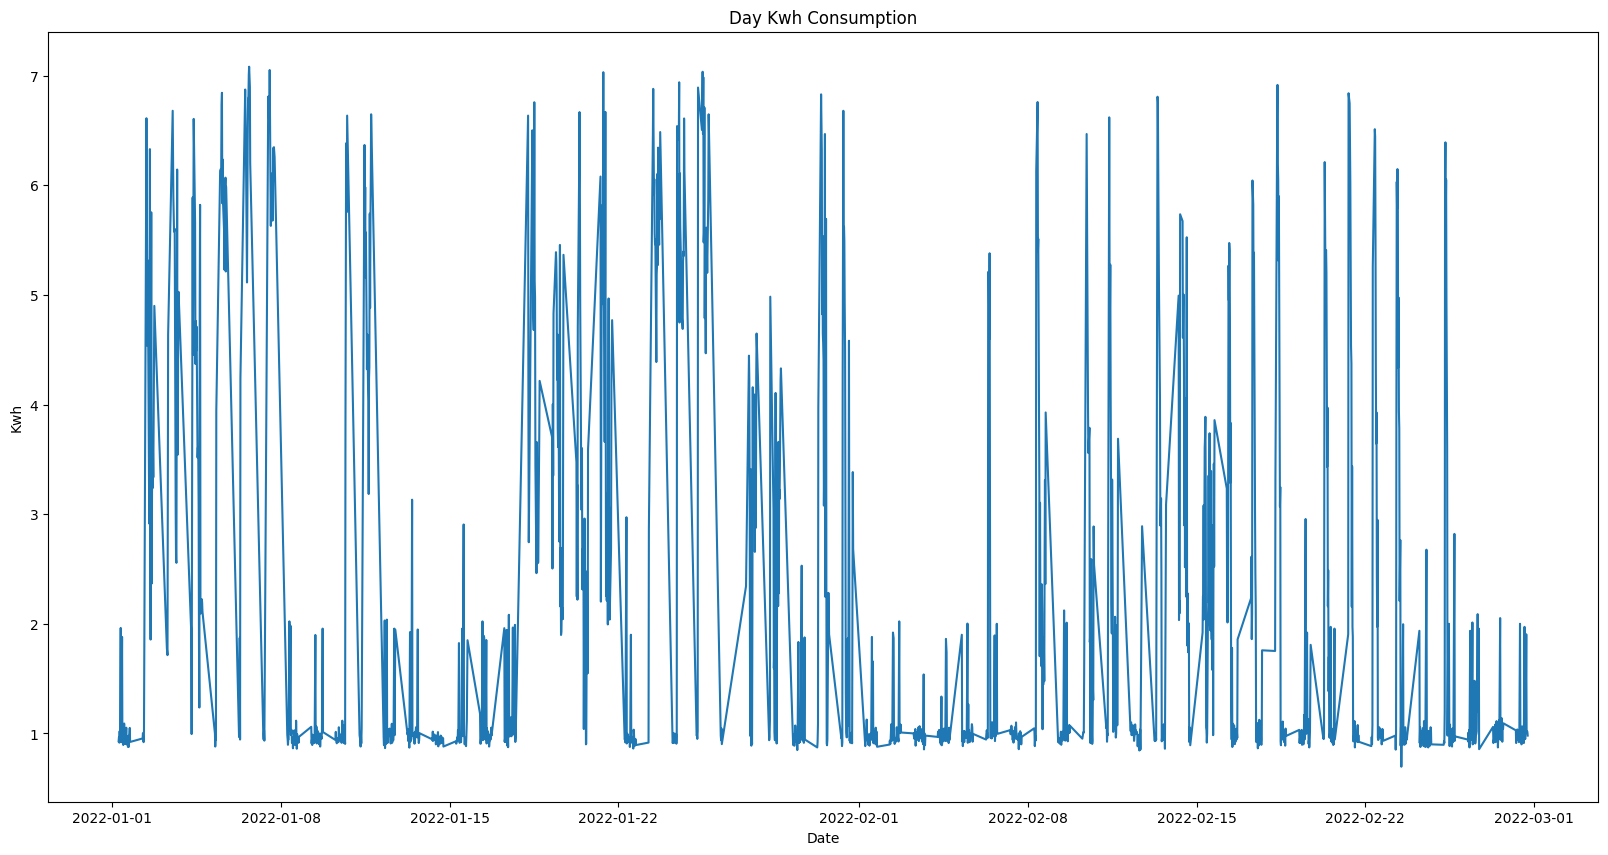

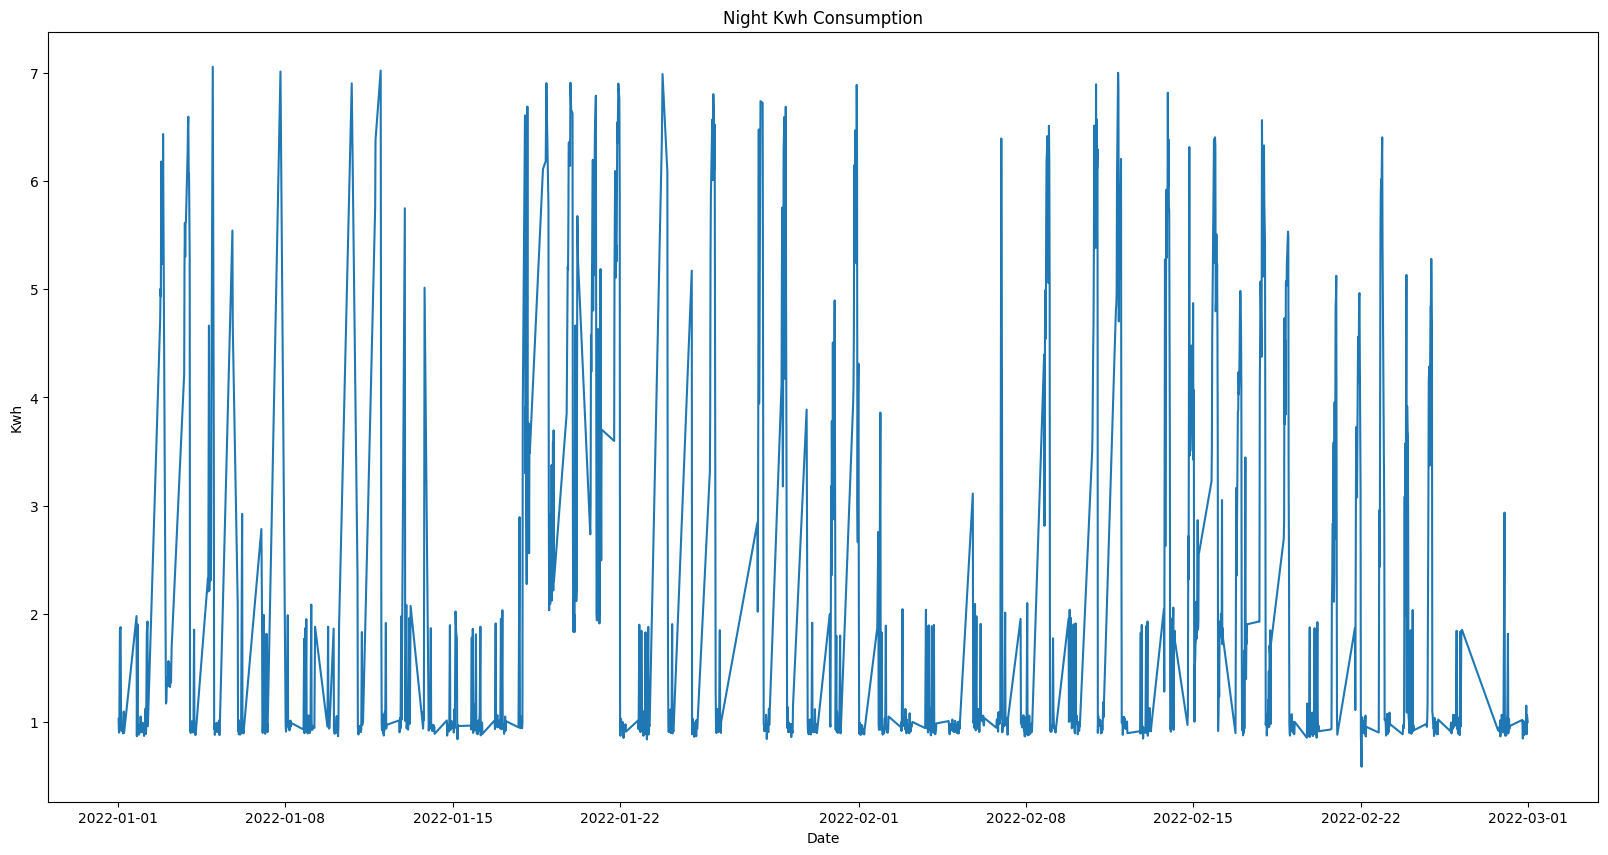

In [217]:
# Graph day and night consumption in separate plots
plt.figure(figsize=(20,10))
plt.plot(day_cons['DateTime'], day_cons['Consumption'])
plt.title('Day Kwh Consumption')
plt.xlabel('Date')
plt.ylabel('Kwh')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(night_cons['DateTime'], night_cons['Consumption'])
plt.title('Night Kwh Consumption')
plt.xlabel('Date')
plt.ylabel('Kwh')
plt.show()

In [218]:
cons = day_cons['Consumption'].values

ts = pd.Series(cons)
SOI = ts.values.reshape(-1)
print (SOI.shape)

(1654,)


In [219]:
# Convert time series to persistence diagram
persistence = SingleTakensEmbedding(parameters_type="search", n_jobs=2)

# Fit transform the time series
diagram = persistence.fit_transform(SOI)
diagram = diagram.reshape(1,*diagram.shape)

In [220]:
diag = diagram[0]

pca = PCA(n_components=3)
comps = pca.fit_transform(diag)

pca.explained_variance_ratio_

array([0.80495264, 0.11585144, 0.04669596])

In [221]:
# Calculating persistent homology
homology = VietorisRipsPersistence(metric="euclidean", homology_dimensions=(0, 1), n_jobs=-1)
comps3 = comps.reshape(1, *comps.shape)
homology_diagram = homology.fit_transform(comps3)

In [222]:
plot_diagram(homology_diagram[0])

In [223]:
embedder_periodic = SingleTakensEmbedding(parameters_type="fixed", n_jobs=2, time_delay=1, dimension=2, stride=1)

y_periodic_embedded = embedder_periodic.fit_transform(cons)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
plot_point_cloud(y_periodic_embedded)

Shape of embedded time series: (1653, 2)


In [224]:
dgmX = ripser.ripser(y_periodic_embedded)['dgms']

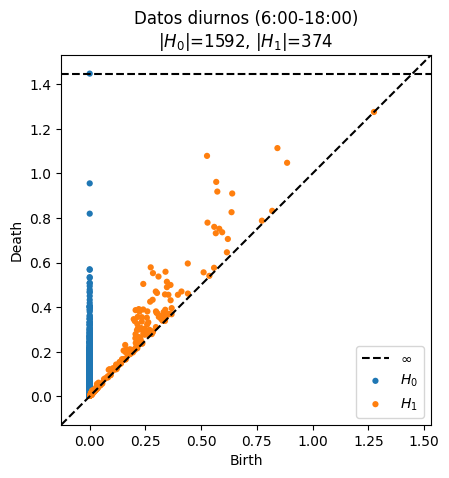

In [225]:
plt.rcParams.update(plt.rcParamsDefault)

persim.plot_diagrams(
    dgmX,
    show=True,
    title=f"Datos diurnos (6:00-18:00)\n{diagram_sizes(dgmX)}"
)

In [226]:
cons = night_cons['Consumption'].values

ts = pd.Series(cons)
SOI = ts.values.reshape(-1)
print (SOI.shape)

(1588,)


In [227]:
# Convert time series to persistence diagram
persistence = SingleTakensEmbedding(parameters_type="search", n_jobs=2)

# Fit transform the time series
diagram = persistence.fit_transform(SOI)
diagram = diagram.reshape(1,*diagram.shape)

In [228]:
diag = diagram[0]

pca = PCA(n_components=3)
comps = pca.fit_transform(diag)

pca.explained_variance_ratio_

array([0.82299666, 0.10468349, 0.04183961])

In [229]:
# Calculating persistent homology
homology = VietorisRipsPersistence(metric="euclidean", homology_dimensions=(0, 1), n_jobs=-1)
comps3 = comps.reshape(1, *comps.shape)
homology_diagram = homology.fit_transform(comps3)

In [230]:
plot_diagram(homology_diagram[0])

In [231]:
embedder_periodic = SingleTakensEmbedding(parameters_type="fixed", n_jobs=2, time_delay=1, dimension=2, stride=1)

y_periodic_embedded = embedder_periodic.fit_transform(cons)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
plot_point_cloud(y_periodic_embedded)

Shape of embedded time series: (1587, 2)


In [232]:
dgmX = ripser.ripser(y_periodic_embedded)['dgms']

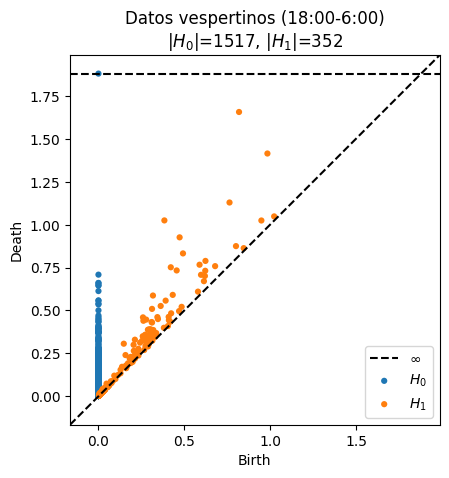

In [233]:
plt.rcParams.update(plt.rcParamsDefault)

persim.plot_diagrams(
    dgmX,
    show=True,
    title=f"Datos vespertinos (18:00-6:00)\n{diagram_sizes(dgmX)}"
)

## Mapper

In [257]:
week_code = np.array([data['DateIndex'].values[i] % 7 for i in range(len(data['DateIndex']))])
data['DayCode'] = week_code

# Add new column to data: if index in day_cons = 1 else 0
data['DayNight'] = data.index.isin(day_cons.index).astype(int)

df_np = np.concatenate((
    data['Consumption'].values.reshape(-1,1),
    data['DateIndex'].values.reshape(-1,1),
    data['DayCode'].values.reshape(-1,1),
    data['DayNight'].values.reshape(-1,1)), axis=1)

# Normalize first column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_np[:,0] = scaler.fit_transform(df_np[:,0].reshape(-1,1)).flatten()

In [258]:
mapper = km.KeplerMapper(verbose=1)

projected_data = mapper.fit_transform(df_np, projection=[0])

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (3242, 4)

..Projecting data using: [0]

..Scaling with: MinMaxScaler()



In [259]:
covering=km.Cover(n_cubes=10,perc_overlap=0.1)
covering

Cover(n_cubes=10, perc_overlap=0.1, limits=None, verbose=0)

In [248]:
# Get the mean difference between average measurements per day
grouped = data.groupby('DateIndex')
print('Diferencia promedio entre medición media diaria:', np.mean([np.mean(np.abs(np.diff(group['Consumption']))) for name, group in grouped]))
print('Diferencia promedio entre registros diarios:', np.mean(np.abs(np.diff(data['DateIndex']))))
print('Diferencia promedio entre mediciones: ', np.mean(np.abs(np.diff(df_np[:,0]))))

Diferencia promedio entre medición media diaria: 0.48688346952805456
Diferencia promedio entre registros diarios: 0.017895711200246838
Diferencia promedio entre mediciones:  0.07500593669783905


In [260]:
G = mapper.map(
    projected_data, 
    df_np, 
    clusterer=sklearn.cluster.MeanShift(cluster_all=False),
    #clusterer=sklearn.cluster.SpectralClustering(n_clusters=8, affinity="nearest_neighbors"),
    #clusterer=sklearn.cluster.OPTICS(max_eps=0.98),
    cover=covering)   

G['meta_data']

Mapping on data shaped (3242, 4) using lens shaped (3242, 1)

Creating 10 hypercubes.



Created 29 edges and 30 nodes in 0:00:05.924264.


{'projection': '[0]',
 'n_cubes': 10,
 'perc_overlap': 0.1,
 'clusterer': 'MeanShift(cluster_all=False)',
 'scaler': 'MinMaxScaler()'}

In [264]:
mapper.visualize(G, 
                title='Consumo eléctrico (Kw/h)',
                # assign color by value of the first column in data
                color_values=df_np[:,2],
                color_function_name = 'Día de la semana',
                node_color_function=np.array(['average','std','sum','max','min']))

Wrote visualization to: mapper_visualization_output.html


/home/soalvasand/.local/lib/python3.8/site-packages/kmapper/visuals.py:344: RuntimeWarning:

invalid value encountered in scalar divide

/home/soalvasand/.local/lib/python3.8/site-packages/kmapper/visuals.py:345: RuntimeWarning:

invalid value encountered in scalar divide



'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Consumo eléctrico (Kw/h) | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n 

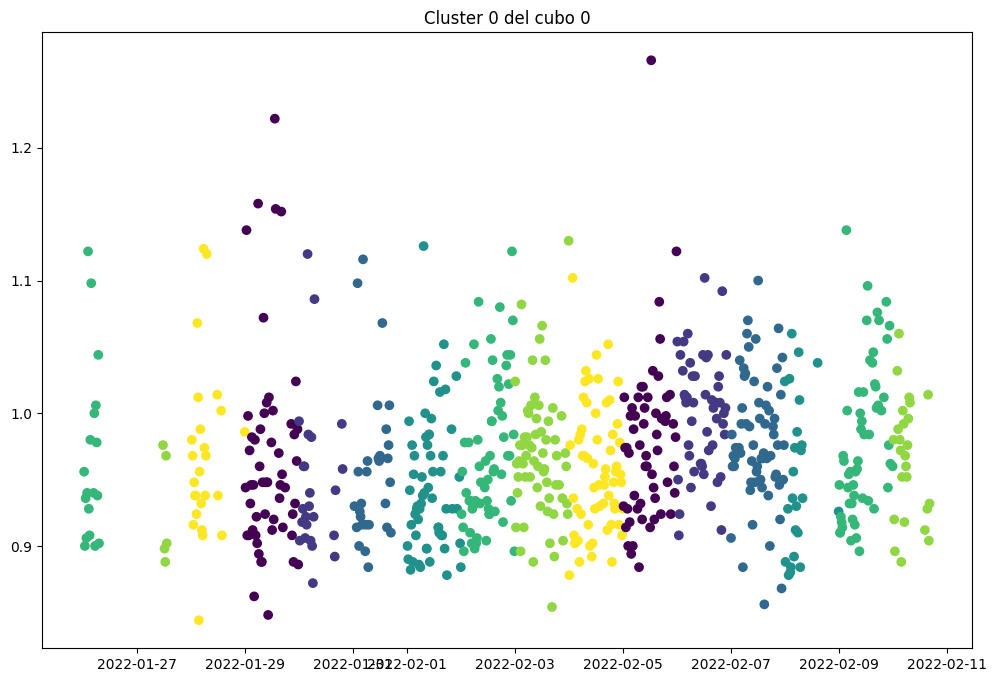

In [305]:
nodeviz = data.loc[G['nodes']['cube0_cluster0']]
fig = plt.figure(figsize=(12,8))

plt.scatter(nodeviz['DateTime'], nodeviz['Consumption'], c = nodeviz['DayCode'])
plt.title('Cluster 0 del cubo 0')
plt.show()